## This notebook follows PMIP4_MH_Ensembles_tas.ipynb

# 3. Calculations -- Hydrological cycle

In [2]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy
from sklearn.metrics import mean_squared_error
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF

In [2]:
pmip_v4='PMIP4'
pmip_v3='PMIP3'
pmip={}
pmip['PMIP4']=['AWI-ESM-1-1-LR',
               'CESM2',
               'EC-EARTH-3-3',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NESM3',
               'NorESM1-F',
               'NorESM2',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
               
  




In [14]:
#No change needs here

'''Define calculating functions'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../DATA" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../DATA/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="../DATA/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

#This function will list excat model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    
#This function will calculate the ensemble average
def ensemble_mean(pmip_v):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            var_1x1=this_regridder(this_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    ensemble_ave_r=np.zeros((180,360))    
    for c in range(360):
        ensemble_ave_r[:,c]=average[:,c-180]            
    return ensemble_ave_r

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble average of the differences
def ensemble_mean_diffence(pmip_v,experiment_name,variable_name):
    model_list=[]
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    ensemble_diff_r=np.zeros((180,360))
    for c in range(360):
        ensemble_diff_r[:,c]=average[:,c-180]
    return ensemble_diff_r

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble stddev of the differences
def ensemble_stddev(pmip_v,experiment_name,variable_name):
    model_list=[]
    dataset=[]
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                dataset.append(diff_1x1)
    data=np.array(dataset)
    std=np.std(data,axis=0)
    stddev_diff_r=np.zeros((180,360))    
    for c in range(360):
        stddev_diff_r[:,c]=std[:,c-180]
    return stddev_diff_r

In [7]:
#This fuction will plot Robinson projected Geo2D map for averaged precipitation rate in mm/day
def pr_ave_plot(data4,data3,data_diff,experiment_name,variable_name):
    cmap=plt.get_cmap('BrBG')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    clim=[-1,1]
    bounds = np.linspace(-1, 1, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(10, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]
    ax1.set_title('PMIP4/CMIP6 ')
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax2.set_title('PMIP3/CMIP5')
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax3.set_title('PMIP4-PMIP3')
    ax3.coastlines()
    ax3.gridlines()
    fig3=ax3.imshow(data_diff, transform=transform,cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig3, cax=cax, **kw,extend='both')
    figname='figs/%s_%s_ave.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    
#Same as above but for uncertainty, i.e. stddev
def pr_std_plot(data4,data3,experiment_name,variable_name):
    cmap=plt.get_cmap('YlGn')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10, 12), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    title= 'PMIP4' 
    ax1.set_title(title)
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    title= 'PMIP3' 
    ax2.set_title(title)
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig2, cax=cax, **kw,extend='max')
    figname='figs/%s_%s_std.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    

# ANN precip

In [15]:
experiment_name='midHolocene'
variable_name='pr_spatialmean_ann'


pr_ann_ensemble_ave_v3=ensemble_mean_diffence(pmip_v3,experiment_name,variable_name)
pr_ann_ensemble_std_v3=ensemble_stddev(pmip_v3,experiment_name,variable_name)
#PMIP4

pr_ann_ensemble_ave_v4=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
pr_ann_ensemble_std_v4=ensemble_stddev(pmip_v4,experiment_name,variable_name)
#diff
pr_ann_ensemble_diff=pr_ann_ensemble_ave_v4-pr_ann_ensemble_ave_v3






Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_18

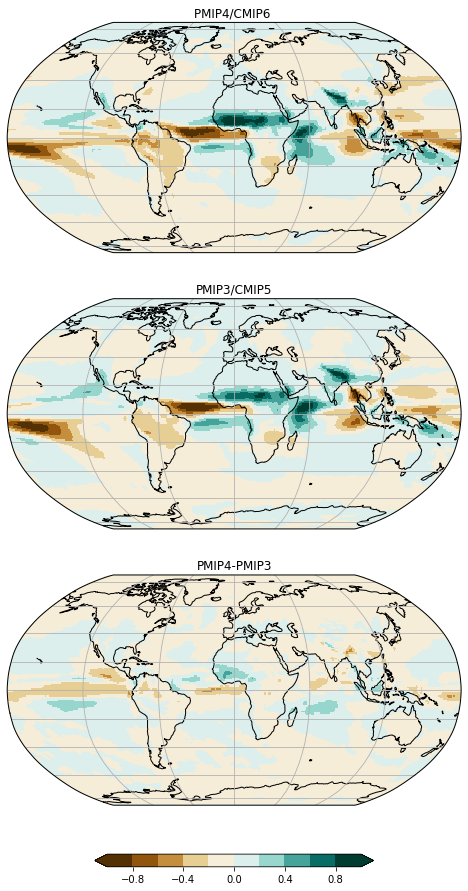

In [17]:
pr_ave_plot1(pr_ann_ensemble_ave_v4,pr_ann_ensemble_ave_v3,pr_ann_ensemble_diff,'midHolocene','pr_spatialmean_ann')

# DJF precip

In [8]:
experiment_name='midHolocene-cal-adj'
variable_name='pr_spatialmean_djf'


pr_djf_ensemble_ave_v3=ensemble_mean_diffence(pmip_v3,experiment_name,variable_name)
pr_dif_ensemble_std_v3=ensemble_stddev(pmip_v3,experiment_name,variable_name)
#PMIP4

pr_djf_ensemble_ave_v4=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
pr_djf_ensemble_std_v4=ensemble_stddev(pmip_v4,experiment_name,variable_name)
#diff
pr_djf_ensemble_diff=pr_djf_ensemble_ave_v4-pr_djf_ensemble_ave_v3







/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'nino34_autocorrelation' has multiple fill values {-1073741800.0, 1e+30}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_48x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180

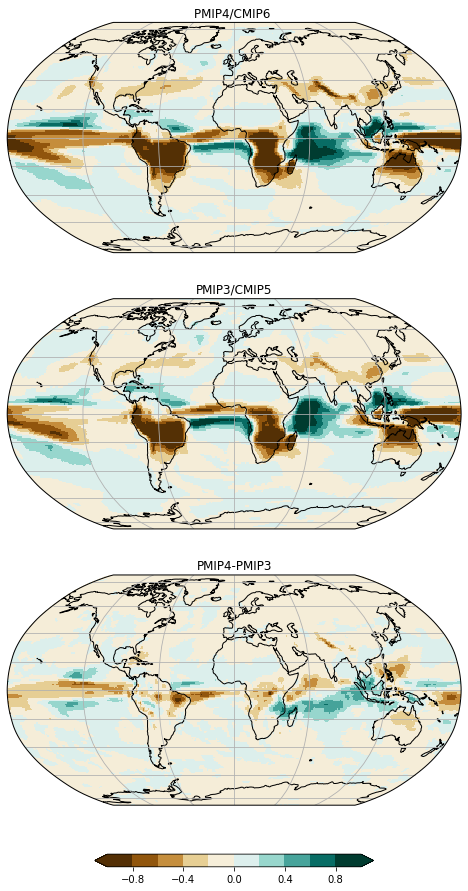

In [9]:
pr_ave_plot(pr_djf_ensemble_ave_v4,pr_djf_ensemble_ave_v3,pr_djf_ensemble_diff,experiment_name,variable_name)

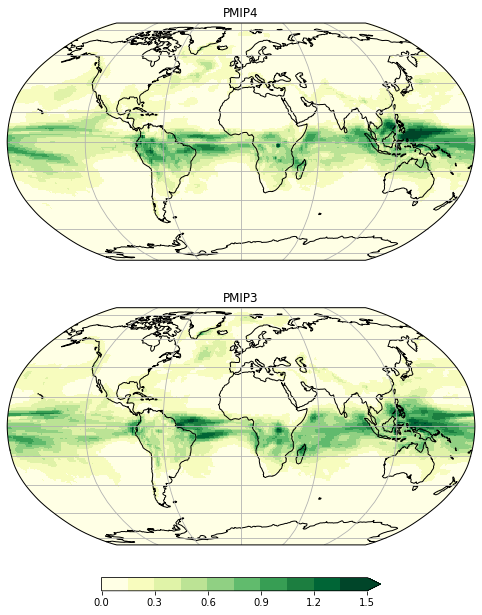

In [10]:
pr_std_plot(pr_djf_ensemble_std_v4,pr_djf_ensemble_std_v3,experiment_name,variable_name)

# JJA precip

In [12]:
experiment_name='midHolocene-cal-adj'
variable_name='pr_spatialmean_jja'


pr_jja_ensemble_ave_v3=ensemble_mean_diffence(pmip_v3,experiment_name,variable_name)
pr_jja_ensemble_std_v3=ensemble_stddev(pmip_v3,experiment_name,variable_name)
#PMIP4

pr_jja_ensemble_ave_v4=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
pr_jja_ensemble_std_v4=ensemble_stddev(pmip_v4,experiment_name,variable_name)
#diff
pr_jja_ensemble_diff=pr_jja_ensemble_ave_v4-pr_jja_ensemble_ave_v3









Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_48x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180

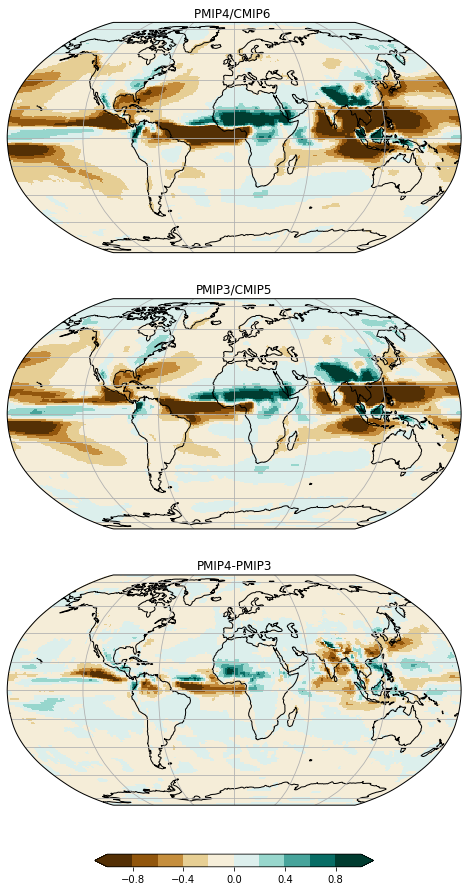

In [13]:
pr_ave_plot(pr_jja_ensemble_ave_v4,pr_jja_ensemble_ave_v3,pr_jja_ensemble_diff,experiment_name,variable_name)

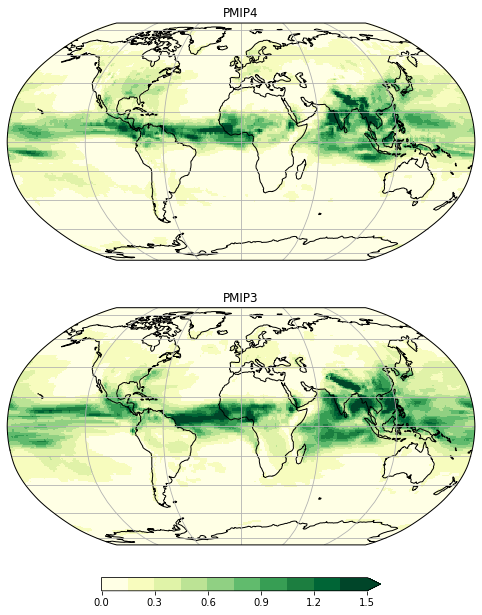

In [14]:
pr_std_plot(pr_jja_ensemble_std_v4,pr_jja_ensemble_std_v3,experiment_name,variable_name)

## Making the pr figure for midHolocene paper

In [3]:
filename='plotting_data/PMIP4_MH_Ensembles_pr_jja.nc'
d=Dataset(filename)
jja3=d.variables['pr_jja_ave_v3'][:]
jja4=d.variables['pr_jja_ave_v4'][:]
jjadiff=d.variables['pr_jja_ave_diff'][:]
jjastd3=d.variables['pr_jja_std_v3'][:]
jjastd4=d.variables['pr_jja_std_v4'][:]
d.close()

filename='plotting_data/PMIP4_MH_Ensembles_pr_djf.nc'
d=Dataset(filename)
djf3=d.variables['pr_djf_ave_v3'][:]
djf4=d.variables['pr_djf_ave_v4'][:]
djfdiff=d.variables['pr_djf_ave_diff'][:]
djfstd3=d.variables['pr_djf_std_v3'][:]
djfstd4=d.variables['pr_djf_std_v4'][:]
d.close()

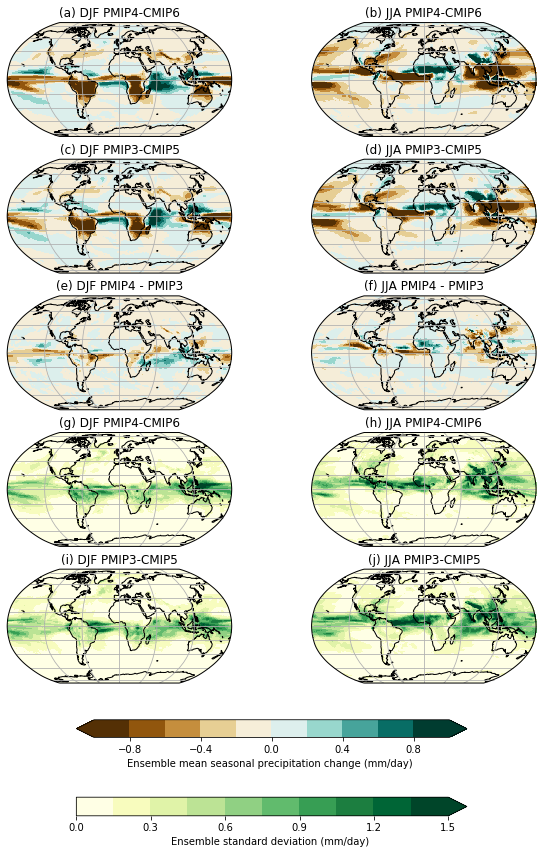

In [4]:
cmap1=plt.get_cmap('BrBG')
projection = ccrs.Robinson()
transform=ccrs.PlateCarree()
clim1=[-1,1]
bounds1 = np.linspace(-1, 1, 11)
norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
cmap2=plt.get_cmap('YlGn')
clim2=[0,1.5]
bounds2 = np.linspace(0, 1.5, 11)
norm2 = colors.BoundaryNorm(boundaries=bounds2, ncolors=256)
fig, axs = plt.subplots(nrows=5,ncols=2,figsize=(10,15),subplot_kw={'projection': ccrs.Robinson()})
ax1=axs[0][0]
ax2=axs[1][0]
ax3=axs[2][0]
ax4=axs[3][0]
ax5=axs[4][0]
ax6=axs[0][1]
ax7=axs[1][1]
ax8=axs[2][1]
ax9=axs[3][1]
ax10=axs[4][1]
ax1.set_title('(a) DJF PMIP4-CMIP6')
ax1.coastlines()
ax1.gridlines()
fig1=ax1.imshow(pr_djf_ensemble_ave_v4, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax2.set_title('(c) DJF PMIP3-CMIP5')
ax2.coastlines()
ax2.gridlines()
fig2=ax2.imshow(pr_djf_ensemble_ave_v3, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax3.set_title('(e) DJF PMIP4 - PMIP3')
ax3.coastlines()
ax3.gridlines()
fig3=ax3.imshow(pr_djf_ensemble_diff, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax4.set_title('(g) DJF PMIP4-CMIP6')
ax4.coastlines()
ax4.gridlines()
fig4=ax4.imshow(pr_djf_ensemble_std_v4, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)
ax5.set_title('(i) DJF PMIP3-CMIP5')
ax5.coastlines()
ax5.gridlines()
fig5=ax5.imshow(pr_djf_ensemble_std_v3, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)
ax6.set_title('(b) JJA PMIP4-CMIP6')
ax6.coastlines()
ax6.gridlines()
fig6=ax6.imshow(pr_jja_ensemble_ave_v4, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax7.set_title('(d) JJA PMIP3-CMIP5')
ax7.coastlines()
ax7.gridlines()
fig7=ax7.imshow(pr_jja_ensemble_ave_v3, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax8.set_title('(f) JJA PMIP4 - PMIP3')
ax8.coastlines()
ax8.gridlines()
fig8=ax8.imshow(pr_jja_ensemble_diff, transform=transform,cmap=cmap1,clim=clim1,norm=norm1)
ax9.set_title('(h) JJA PMIP4-CMIP6')
ax9.coastlines()
ax9.gridlines()
fig9=ax9.imshow(pr_jja_ensemble_std_v4, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)
ax10.set_title('(j) JJA PMIP3-CMIP5')
ax10.coastlines()
ax10.gridlines()
fig10=ax10.imshow(pr_jja_ensemble_std_v3, transform=transform,cmap=cmap2,clim=clim2,norm=norm2)

cax2,kw2 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb2=plt.colorbar(fig4, cax=cax2, **kw2,extend='max')
cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb1=plt.colorbar(fig3, cax=cax1, **kw1,extend='both')

cb1label='Ensemble mean seasonal precipitation change (mm/day) '
cb2label='Ensemble standard deviation (mm/day) '
cb1.set_label(cb1label)
cb2.set_label(cb2label)
